## **0. 루브릭**

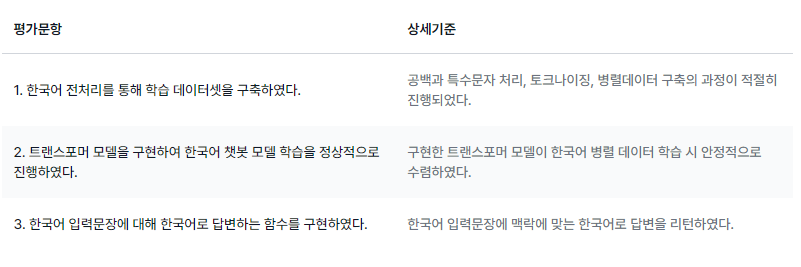

## **1. 기존 챗봇**

### **트랜스포머 구조 살펴보기**
***

트랜스포머는 어텐션 매커니즘만으로 구성된 모델.

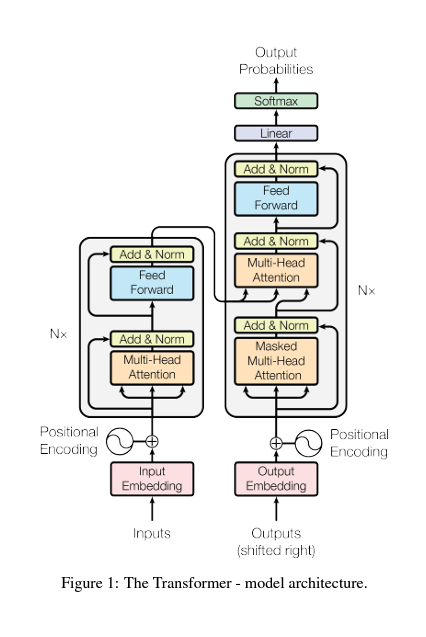

트랜스포머는 크게 보면 **인코더 층(Encoder layer, 왼쪽)** 과 **디코더 층(Decoder layer, 오른쪽)**으로 나뉘어져 있음.

각 블록은 N개씩 반복 배치되므로, 인코딩 층 N개가 이어져 있고, 디코더 층 N개가 이어짐.

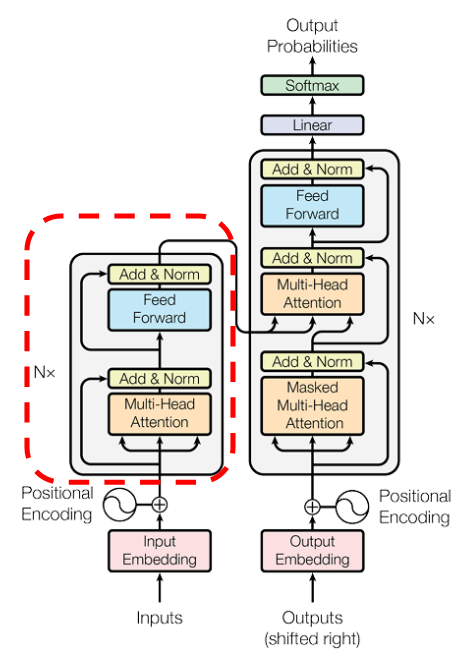

인코딩 층에는 2개의 서브레이어가 있음.

**멀티헤드 셀프 어텐션** (혹은 **인코더 셀프 어텐션**)과 **피드포워드 신경망**

이 둘을 N번 반복 통과한 후, 디코더 층으로 계산 결과를 보내게 됨.

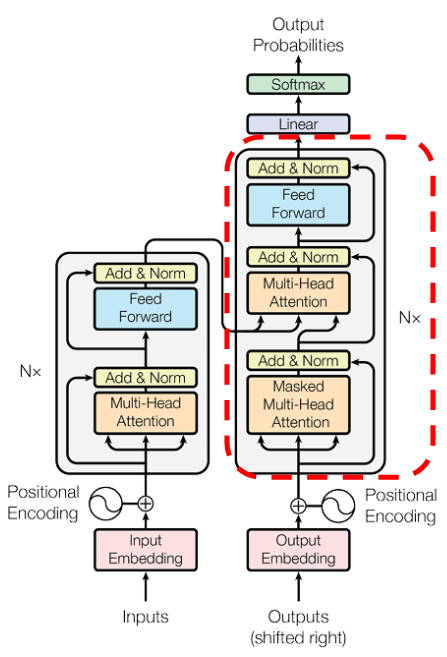

디코더 층에는 3개의 서브레이어가 있음.

**마스크드 멀티헤드 셀프 어텐션** (혹은 **디코더 셀프 어텐션**), **멀티헤드 어텐션** (혹은 **인코더-디코더 셀프 어텐션**)과 **피드포워드 신경망**

N번 반복 통과한 후, 계산 결과를 출력해내게 됨.

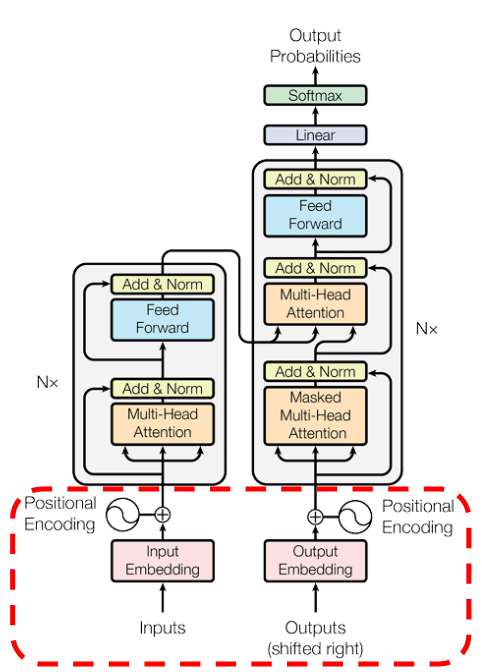

마지막으로, 인코더 층/디코더 층에 임베딩 출력을 입력하기 전에 포지셔널 인코딩을 합치게 됨.

### **인코더와 디코더 구조 되짚어보기**
***

대표적인 모델인 인코더와 디코더 구조를 되짚어 봅시다.

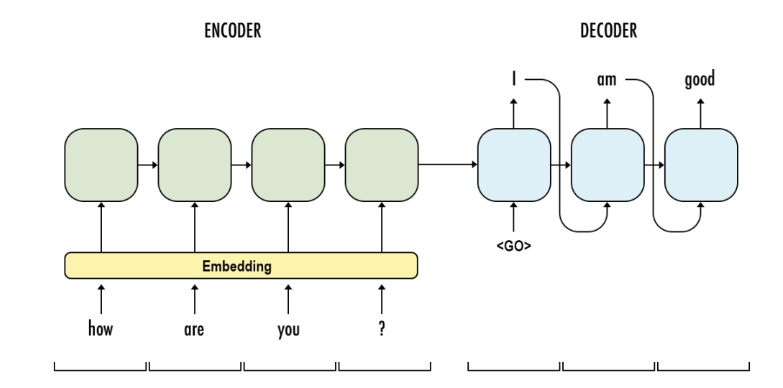

인코더에 입력 문장이 들어가고, 디코더는 이에 상응하는 출력 문장을 생성함.

이를 훈련한다는 것은 입력 문장과 출력 문장 두 가지 병렬 구조로 구성된 데이터셋을 훈련한다는 의미임.

**(번역) 입력: '저는 학생입니다' → 출력: 'I am a student'**

질문에 대해 대답을 하도록 구성된 데이터셋을 인코더와 디코더 구조로 학습하면, 주어진 질문에 답변할 수 있는 챗봇도 만들 수 있음.

**(질문-답변) 입력: '오늘의 날씨는 어때?' → 출력: '오늘은 매우 화창한 날씨야'**

### **트랜스포머의 인코더와 디코더**
***

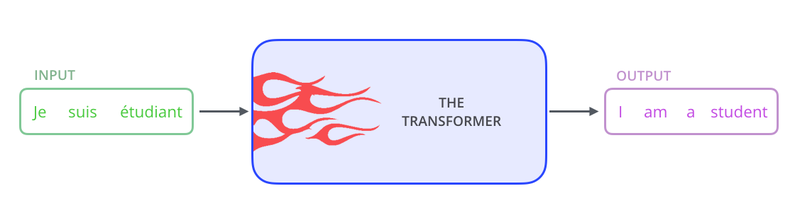

위에 블랙박스로 가려져 있는 Transformer의 내부 구조를 열어보면 다음과 같음.

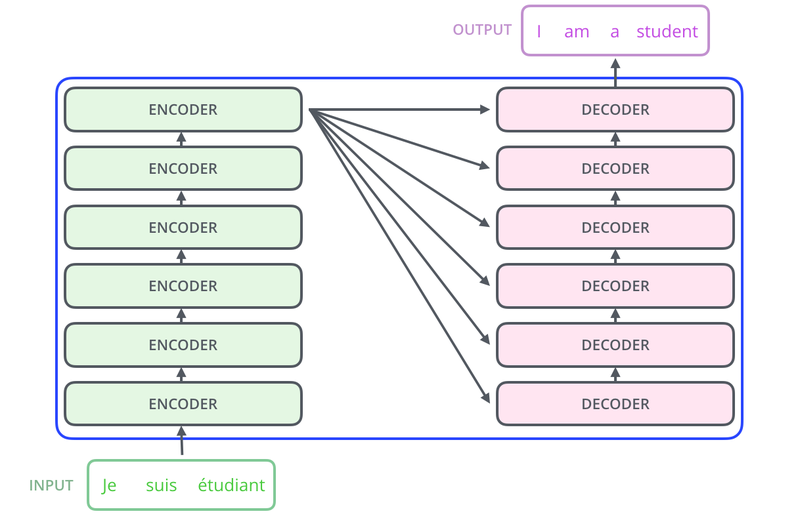

초록색 색깔의 도형을 **인코더 층(Encoder layer)**, 핑크색 색깔의 도형을 **디코더(Decoder layer)** 라고 하였을 때, **입력 문장**은 누적해 쌓아 올린 인코더의 층을 통해서 정보를 뽑아내고, 디코더는 누적해 쌓아 올린 디코더의 층을 통해서 **출력 문장**의 단어를 하나씩 만들어가는 구조를 갖고 있음.

내부를 확대해보면 여러 가지 부품들로 구성되어 있음.

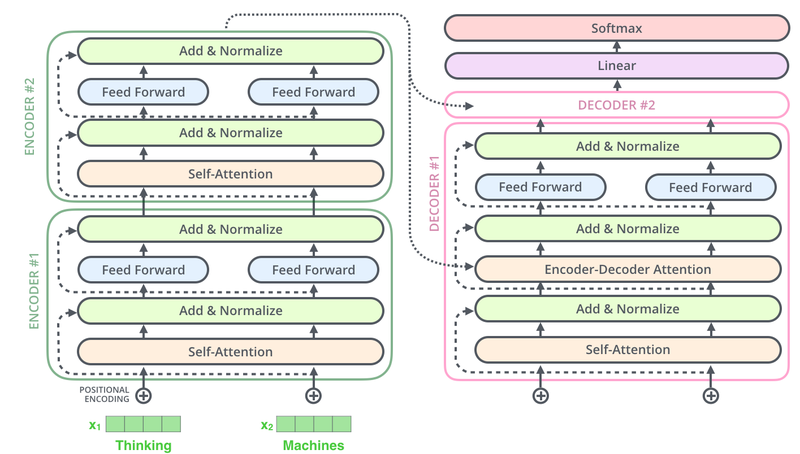

### **트랜스포머의 입력 이해하기**
***

In [1]:
# 필요한 라이브러리를 불러오기
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

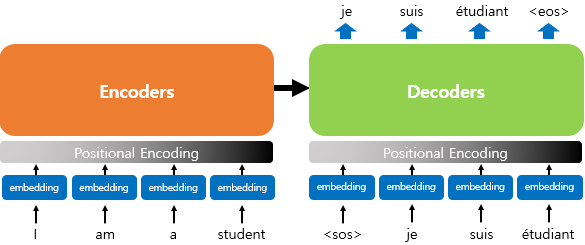

많은 자연어 처리 모델들은 텍스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정을 거침.

트랜스포머 모델도 그 중 하나이지만, 다른 RNN 계열의 모델과 달리 **임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용**함. 그 값은 `포지셔널 인코딩(positional Emcoding)`에 해당하는 부분임.

인코더의 입력 부분을 조금 더 확대해 본다면 다음과 같은 그림이 그려질 것임.

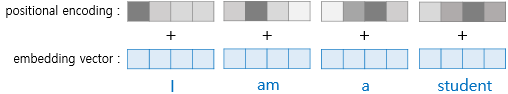

이렇게 해주는 이유는 트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 

**문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문**임.

**RNN**에는 문장을 구성하는 단어들이 어순대로 모델에 입력되므로, 모델에게 따로 어순 정보를 알려줄 필요가 없지만,

**트랜스포머**는 문장에 있는 모든 단어를 한꺼번에 문장 단위로 입력받기 때문에, **어순을 구분할 수 없음**.

그래서 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려주기 위해

단어의 임베딩 벡터에 **위치 정보를 가진 벡터(Positional Encoding)** 값을 더해서 모델의 입력으로 삼는 것임.

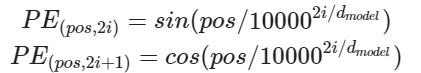

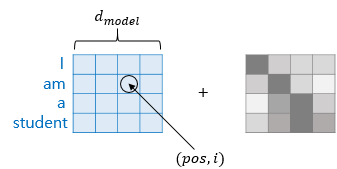

트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해줌으로써 단어의 순서 정보를 더하여 줌.

임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 벡터 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어짐.

d_model은 임베딩 벡터의 차원을 의미하고 있고, pos는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, i는 임베딩 벡터 내의 차원의 인덱스를 의미함.

임베딩 행렬과 포지셔널 행렬이라는 두 행렬을 더함으로써 각 단어 벡터의 위치 정보를 더해주는 것임.

**Q. 한 문장에 같은 단어 A가 여러 번 등장하였다고 가정해보겠습니다. 임베딩 문장 행렬에 포지셔널 인코딩을 해주었을 때와 해주지 않았을 때, 트랜스포머가 임베딩 문장 행렬 내의 다수의 A 단어 벡터로부터 얻을 수 있는 정보의 차이는 어떤 것이 있을까요?**

같은 단어라고 하더라도 포지셔널 인코딩을 해준 경우에는 임베딩 벡터값이 달라지므로, 같은 단어라고 해도 각각 다른 위치에 등장했다는 사실을 모델에 알려줄 수 있습니다.

**포지셔널 행렬(positional metrix)** 을 직접 구현해서 눈으로 확인해보자.

In [2]:
# positional encoding layer
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

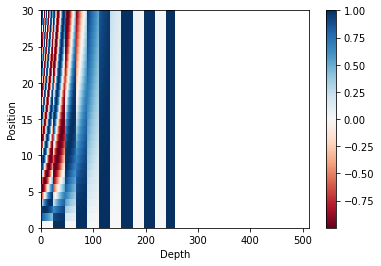

In [3]:
# 임베딩 벡터의 차원이 256이고, 최대 문장의 길이가 30인 텍스트를 입력으로 하는
# 트랜스포머를 구현한다고 했을 때, 적절한 positional encoding metrix의 크기를 추측해보고
# 위에 구현한 positional encoding layer를 사용해 표현해보자.
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### **어텐션이란?**
***

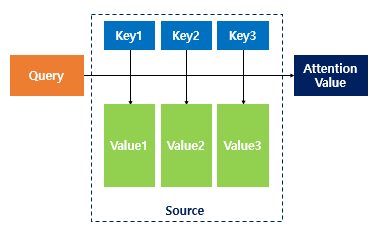

어텐션 함수는 주어진 **'쿼리(Query)'**에 대해서 모든 **'키(Key)'**와의 유사도를 각각 구함.

그리고 구해낸 이 유사도를 **'키(Key)'**와 맵핑되어 있는 각각의 **'값(Value)'**에 반영해 줌.

유사도가 반영된 **'값(Value)'**을 모두 더해서 뭉쳐주면 이를 최종 결과인 **'어텐션 값(attention value)'**라고 함.

### **트랜스포머에서 사용된 어텐션**
***

트랜스포머는 총 세 가지의 어텐션을 사용함.

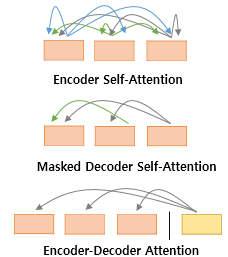

첫 번째 그림인 **인코더 셀프 어텐션**은 **인코더**에서 이루어지고 있고,

두 번째 그림인 **디코더 셀프 어텐션**은 **디코더**에서 이루어지며,

세 번째 그림인 **인코더-디코더 어텐션** 또한 **디코더**에서 이루어짐.

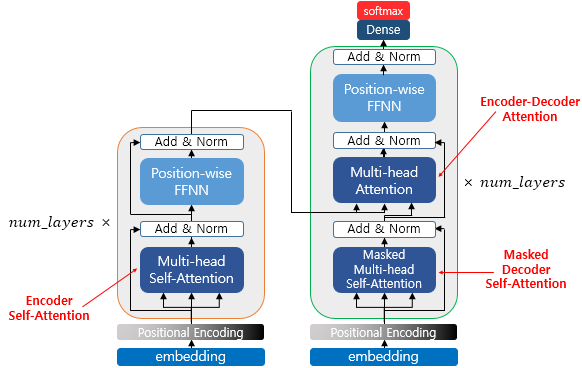

위 그림은 트랜스포머의 전체적인 아키텍처에서 각 어텐션이 위치한 곳을 보여줌.

트랜스포머의 어텐션 함수에 사용되는 **쿼리(Query)**, **키(Key)**, **밸류(Value)** 는 기본적으로 **'단어 (정보를 함축한) 벡터, ㅡ트랜스포머의 여러 연산을 거친 후의 단어 후'**.

위 세 가지 어텐션이 하는 일
* **인코더 셀프 어텐션(encoder self attention)** : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
* **디코더 셀프 어텐션(masked decoder self attention)** : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
* **인코더-디코더 어텐션(encoder-decoder attention)** : 디코더가 잘 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

### **셀프 어텐션(self-attention)**
***

**셀프 어텐션**이란, 유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우임.

**인코더-디코더 어텐션**은 서로 다른 목록(인코더 내 단어와 디코더 내 단어) 사이에서 유사도를 구하기에 **셀프 어텐션이 아님**.

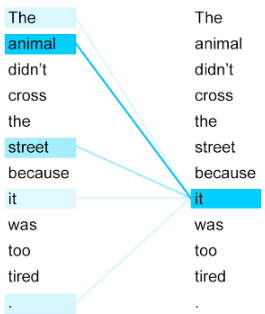

[Transformer Model(Google AI Blog Post)](https://research.google/blog/transformer-a-novel-neural-network-architecture-for-language-understanding/)

문장을 번역하면 다음과 같음.

**"그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다."**

여기서 **그것(it)** 에 해당하는 것은 과연 **길(street)**인가? **동물(animal)**인가?

우리는 동물이라는 것을 쉽게 알 수 있지만, 기계는 그렇지 않음.

하지만 셀프 어텐션은 입력 문장 내의 단어들끼리 유사도를 구하여 **그것(it)**이 **동물(animal)**과 연관되었을 확률이 높다는 것을 찾아냄.

**Q. 트랜스포머에서 사용되는 어텐션 중 셀프 어텐션을 사용하지 않는 것은 무엇인가요? 그리고 다른 어텐션과 차이점은 무엇인가요?**

**인코더** : 디코더 어텐션은 셀프 어텐션을 사용하지 않고, 다른 어텐션은 다른 문장의 단어가 아닌 현재 문장 내의 단어들의 유사도를 구한는 것임.

**인코더-디코더 어텐션** : 인코더에 입력된 단어들과 디코더에서 생성된 문장의 단어들과의 유사도를 구함. 앞에서 나온 번역의 예시인 입력 문장 `저는 학생입니다.`와 출력 문장 `I am a student`에서 '학생' 단어가 `I`, `am`, `a`, `student` 중 어떤 단어와 유사한지 계산하는 것임.

### **scaled dot product attention**
***

$$
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{Q K^T}{\sqrt{d_k}} \right) V
$$

Q, K, V는 각각 **쿼리(Query)**, **키(Key)**, **값(Value)**를 나타냄.

1. **Q**, **K**, **V**는 단어 벡터를 행으로 하는 문장 행렬이다.
2. 벡터의 **내적(dot product)** 은 벡터의 유사도를 의미한다.
3. 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 **스케일링(Scaling)**을 위함이다.

***
우선 𝑄와 𝐾의 전치 행렬을 곱하는 것을 그림으로 표현하면 다음과 같음.

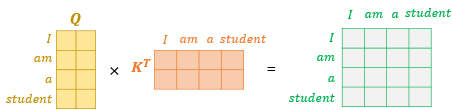

문장 행렬 𝑄와 문장 행렬 𝐾를 곱하면 위의 그림과 같은 초록색 행렬을 얻을 수 있음.

예를 들어 'am' 행과 'student' 열의 값은 𝑄 행렬에 있던 'am' 벡터와 𝐾 행렬에 있던 'student 벡터'의 내적값을 의미함.

**결국 각 단어 벡터의 유사도가 모두 기록된 유사도 행렬이 되는 것임.**

***
이 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나누어주고, 유사도를 0과 1 사이의 값으로 Normalize 해주기 위해서 softmax 함수를 사용함. (Q와 K의 유사도를 구하는 과정)

여기에 문장 행렬 V와 곱하면 **어텐션 값(Attention Value)** 를 얻음.

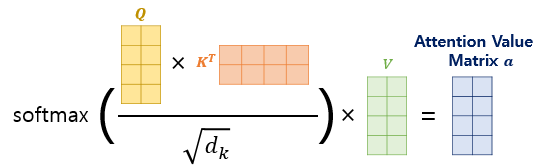

이 수식은 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나누어주는 방식으로 Q와 K의 유사도를 구했기에 **Scaled Dot Product Attention**이라고 함.

**dot product attention**은 분모에 특정 값을 나눠주는 부분을 사용하지 않았을 경우의 어텐션

**Q. 특정 값을 분모로 사용하여 스케일링(Scaling)을 하는 이유는 무엇인가요?**

스케일링을 하지 않으면 벡터의 내적(dot product) 연산의 결과가 입력 벡터의 차원 수에 따라 크기가 매우 커지게 되고, softmax의 출력값이 작아지는 것을 방지하기 위해서임. softmax의 출력값이 작아지면 역전파 과정에서 기울기 소실 문제가 발생할 수 있음.

In [4]:
# scaled dot product attention
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### **병렬과 어텐션 수행하기**
***

트랜스포머에서 `num_head`라는 변수는 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터

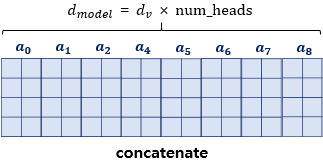

`d_model`은 임베딩 벡터의 차원

결국 트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이를 행으로, `d_model`을 열의 크기로 가짐.

트랜스포머는 이렇게 입력된 문장 행렬을 `num_heads`의 수만큼 쪼개서 어텐션을 수행하고, 이렇게 얻은 `num_heads`의 개수만큼의 어텐션 값 행렬을 다시 하나로 concatenate함.

위 그림에서는 `num_heads`가 8개인 경우인데, 다시 concatenate하면서 열의 크기가 `d_model`이 됨.

**Q. 논문에서 `d_model`은 512의 값을 가졌다고 하고, `num_heads`는 8의 값을 가졌다고 해요. 그렇다면, 연결하기 전 8개의 어텐션 값(Attention Value 행렬의 열의 크기는 몇 차원이었을까요?**

512 / 8  = 64 차원

### **멀티-헤드 어텐션(Multi-Head Attention)**
***

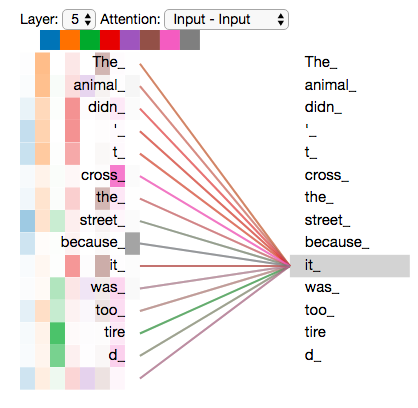

`num_heads`의 값이 8일 때, 병렬로 수행되는 어텐션이 서로 다른 어텐션 결과를 얻을 수 있음.

**다시 말해 8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있음**

예를 들어 위 그림에서라면 `it_`이라는 토큰이 `animal_`과 유사하다고 보는 관점과 `street_`과 유사하다고 보는 관점이 한꺼번에 모두 표현 가능함.

어텐션을 병렬로 수행하는 것을 **멀티 헤드 어텐션(Multi-Head Attention)**임.

In [5]:
# 멀티 헤드 어텐션(Multi-Head Attention) 구현하기
# 내부적으로는 스케일드 닷 프로덕트 어텐션 함수를 호출하기
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### **마스킹(Masking)**
***

**마스킹(Masking)** 이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법

### **패딩 마스킹(Padding Masking)**
***

첫 번째 마스킹은 **패딩 토큰(Padding token)**을 이용한 방법.

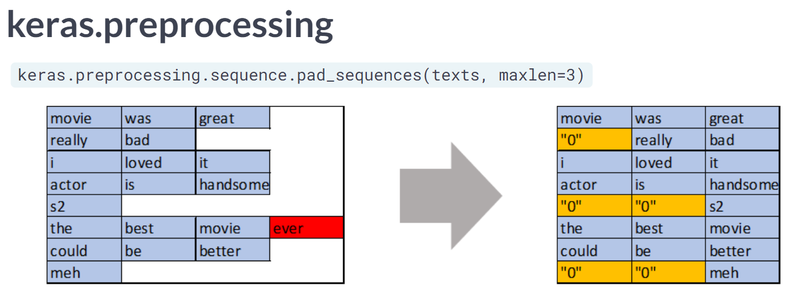

keras의 `pad_sequences()`를 사용하여 패딩하는 과정을 구현한 그림임.

패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법임.

그런데 실제 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있음. 

**패딩 마스킹**은 이를 위해 숫자 0인 위치를 체크함.

In [6]:
# 패딩 마스킹을 구현한 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
# 두 개의 정수 시퀀스를 입력으로 해보고, 어떤 결과가 나오는지 보자.
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


두 정수 시퀀스에 대해서 각각 결과가 출력되는데, 오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력함.

### **룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)**
***

* RNN은 **step**이라는 개념이 존재해서 각 **step**마다 단어가 순서대로 입력으로 들어가는 구조임.
* 트랜스포머는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있기에, **마스킹(Masking)**을 필요로 함.

트랜스포머는 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있음.

하지만 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것임.

**룩 어헤드 마스킹(Look-ahead masking)**은 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법

어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹함.

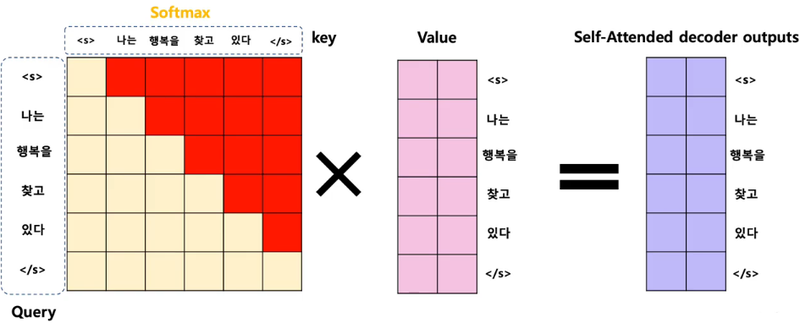

빨간색으로 색칠된 부분은 마스킹을 표현하고 있음.

빨간색은 실제 어텐션 연산에서 거리는 역할을 하여 어텐션 연산 시에 현재 단어를 기준으로 이전 단어들하고만 유사도를 구할 수 있음.

행을 Query, 열을 Key로 표현된 행렬임을 감안해보자.

ex. Query 단어가 `찾고`라면,

이 `찾고`라는 행에는 `<s>`, `<나는>`, `<행복을>`, `<찾고>` 까지의 열만 보이고 아예 빨간색으로 칠해져 있음. (즉, 유사도를 구할 수 없도록 해놓음)

In [8]:
# 빨간색 부분을 마스킹 함수로 구현하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [9]:
# 직접 입력을 넣어 테스트해보기
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


대각선의 형태로 숫자 1이 채워지는 것을 볼 수 있음.

이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩해야 함.

그래서 `create_look_ahead_mask()` 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출하고 있음.

In [10]:
# 숫자 0이 포함되었을 경우에도 테스트해보기
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### **인코딩 층 만들기**
***

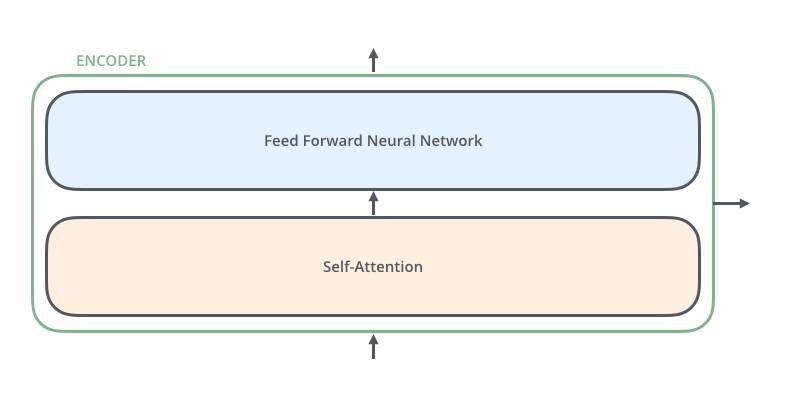

하나의 인코더 층은 크게 2개의 서브 층(sublayer)으로 나누어짐. **셀프 어텐션**과 **피드 포워드 신경망**

두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같음.

함수 내부적으로 첫 번째 서브 층과 두 번째 층을 구현하고 있음.

In [11]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

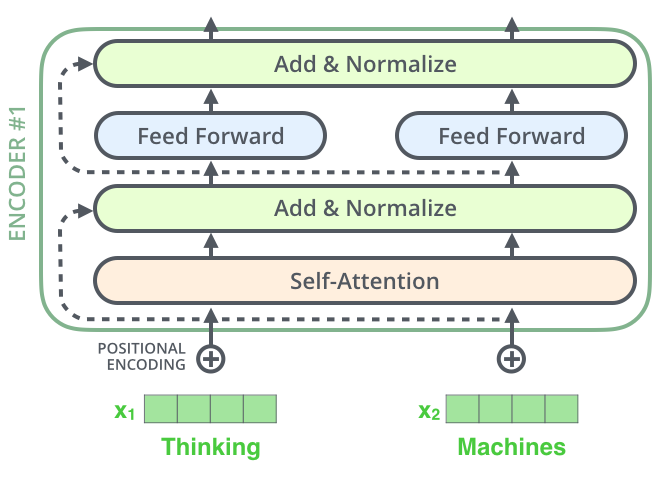

### **인코더 층을 쌓아 인코더 만들기**
***

**인코더 층**을 **임베딩 층(Embedding layer)** 과 **포지셔널 인코딩(Positional Encoding)** 을 연결하고, 사용자가 원하는 만큼 **인코더 층**을 쌓음으로써 트랜스포머의 인코더가 완성됨.

인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 **Layer Normalization**이라는 테크닉이 사용됨. 위 그림에서는 **Normalize**라고 표시된 부분에 해당됨.

트랜스포머는 하이퍼파라미터인 `num_layers` 개수의 인코더 층을 쌓음.

논문에서는 총 6개의 인코딩 층을 사용했지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 것임.

In [12]:
# 인코더 층을 쌓아 인코더 만들기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### **디코더 층**
***

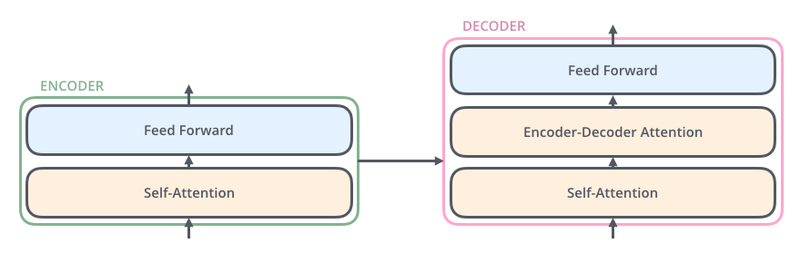

**인코더-디코더 어텐션**은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면 Key와 Value가 인코더의 벡터라는 특징이 있음.

이 부분이 입력 문장으로부터 정보를 디코더에 전달하는 과정임.

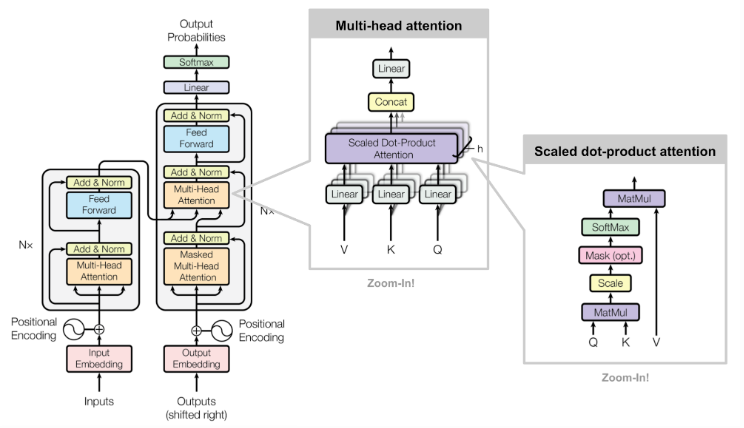

디코더의 **셀프 어텐션**, **인코더-디코더 어텐션** 두 개의 어텐션 모두 **스케일드 닷 프로덕트 어텐션**을 **멀티 헤드 어텐션**으로 병렬적으로 수행함.

디코더의 세 개의 서브 층을 내부적으로 구현한 디코더의 함수는 다음과 같음.

In [13]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### **디코더 층을 쌓아 디코더 만들기**
***

디코더의 층은 **임베딩 층(Embedding layer)** 과 **포지셔널 인코딩(Positional Encoding)** 을 연결하고, 사용자가 원하는 만큼 **디코더 층**을 쌓아 트랜스포머의 디코더가 완성됨.

인코더와 마찬가지로 `num_layers` 개수의 디코더 층을 쌓음.

논문에서는 총 6개의 인코딩 층을 사용했지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 것임.

In [14]:
# 디코더 층을 쌓아 디코더 만들기
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

인코더 층과 디코더 층을 각각 함수로 구현하였음.

이를 하나로 조합하여 트랜스포머 모델을 만들 수 있음.

### **챗봇의 병렬 데이터 받아오기**
***

**Cornell Movie-Dialogs Corpus**라는 영화 및 TV 프로그램에서 사용되었던 대화의 쌍으로 구성된 데이터셋을 사용함.

대화의 쌍이라고 하는 것은 기본적으로 먼저 말하는 사람의 대화 문장이 있고, 그에 응답하는 대화 문장의 쌍으로 이루어짐.

데이터를 받아오는 이번 스텝에서 목표로 하는 것은 다음과 같음.

1. 정해진 개수인 50,000개의 질문과 답변의 쌍을 추출한다.
2. 문장에서 단어와 구두점 사이에 공백을 추가한다.
3. 알파벳과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거한다.

In [15]:
# 데이터 다운로드하기
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

여기서 우리가 사용할 데이터는 실습 시간을 고려하여 전체 데이터 중 일부임.

우선, 데이터 중에서 5만 개만 가져오도록 하고 질문과 답변의 쌍의 형태로 데이터셋을 가공함.

In [16]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


전처리는 **정규 표현식(Regular Expression)** 을 사용하여 **구두점(punctuation)** 을 제거하여 단어를 **토크나이징(tokenizing)** 하는 일에 방해가 되지 않도록 정제하는 것을 목표로 함.

In [17]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

데이터를 로드하는 동시에 전처리 함수를 호출하여 질문과 답변의 쌍을 전처리함.

In [18]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

이렇게 로드한 데이터 샘플 수를 확인해보자.

In [19]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 50000
전체 샘플 수 : 50000


질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확히 일치해야 함.

둘 다 5만 개의 샘플이 저장됨.

임의로 22번째 샘플(인덱스 상으로는 21번 샘플)을 출력해서 질문과 답변이 병렬적으로 잘 저장은 되었는지, 

그리고 전처리 함수에서 의도했던 전처리가 진행되었는지 확인해 보자.

In [20]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: she s not a . . .
전처리 후의 22번째 답변 샘플: lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


`?`나 `.`과 같은 구두점들이 단어들과 분리되어 단어와 구두점 사이에는 공백이 추가된 것을 확인할 수 있음.

 이렇게 함으로써 단어를 토크나이징 하는 과정에서 구두점과 붙어있던 단어들을 하나의 단어로 인식하는 것을 방지할 수 있음.

### **병렬 데이터 전처리하기**
***

질문과 답변의 셋을 각각 `question`와 `answers`에 저장하였으므로, 본격적으로 전처리를 진행해보자.
1. TensorFlow Datasets **SubwordTextEncoder**를 토크나이저로 사용한다. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 **정수로 인코딩**한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 `START_TOKEN` 및 `END_TOKEN`을 추가한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 **패딩**한다.

### **1. 단어장(Vocabulary) 만들기**
***

각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들어보자.

단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만듦.

In [21]:
import tensorflow_datasets as tfds
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

이때 디코더의 문장 생성 과정에서 사용할 `'시작 토큰'`과 `'종료 토큰'`에 대해서도 임의로 단어장에 추가하여서 정수를 부여함.

이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여하면 됨.

In [22]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

시작 토큰과 종료 토큰에 부여된 정수를 출력해보자.

In [23]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8331]
END_TOKEN의 번호 : [8332]


각각 8,331과 8,332라는 점에서 현재 단어장의 크기가 8,331(0번 ~ 8,330번)이라는 의미임.

두 개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 함.

In [24]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8333


### **2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)**
***

`tensorflow_datasets`의 `SubwordTextEncoder`를 사용해서 **tokenizer**를 정의하고 **Vocabulary**를 만들었다면, 

`tokenizer.encode()`로 각 단어를 정수로 변환할 수 있고 또는 `tokenizer.decode()`를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있

예를 들어 22번째 샘플을 `tokenizer_encode()`의 입력으로 사용해서 변환 결과를 보자.

In [25]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [60, 8, 37, 8172, 49]
정수 인코딩 후의 21번째 답변 샘플: [7824, 1223, 19, 61, 2, 4, 336, 10, 1595, 14, 1104, 698, 3263, 263, 16, 71, 14, 107, 2133, 900, 3, 59, 4, 23, 355, 204, 60, 8, 37, 885, 2289, 8107, 344, 1001, 5179, 4214, 342, 1]


각 단어에 고유한 정수에 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있음.

위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 **정수 인코딩**을 수행함. 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 **패딩(padding)** 함.

In [26]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [27]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

정수 인코딩 과정을 수행하면서 샘플의 길이가 40을 넘는 경우는 샘플들을 필터링했으므로 일부 샘플이 제외됨.

단어장의 크기와 샘플의 개수를 확인해보자.

In [28]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8333
필터링 후의 질문 샘플 개수: 44095
필터링 후의 답변 샘플 개수: 44095


### **3. 교사 강요(Teacher Forcing) 사용하기**
***

**tf.data.Dataset API** 는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API

이를 적극 사용하기 위해 질문과 답변의 쌍을 `tf.data.Dataset`의 입력으로 넣어주는 작업을 함.

디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 **교사 강요(Teacher Forcing)** 언어 모델의 훈련 기법을 이해해야만 함.

**Q. 교사 강요(Teacher Forcing) 를 사용하지 않았을 경우, 훈련 과정에서 훈련 속도가 지나치게 느려지는 경우가 있다고 합니다. 그 이유는 무엇인가요?**

교사 강요를 하지 않은 경우, 잘못된 예측이 다음 시점(time step)의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 미친다.

이전 자신의 출력이 자신의 상태를 결정하는 모델을 **자기회귀 모델(auto-regressive model, AR)**이라고 함.

앞서 교사 강요를 이해하기 위해 읽었던 글에 등장한 RNN 언어 모델은 대표적인 자기 회귀 모델의 예이며, 트랜스포머의 디코더 또한 자기회귀 모델.

트랜스포머 디코더에서도 **교사 강요(Teacher Forcing)**를 적용함.

**Q. 만약, answers의 한 샘플이 다음과 같았다고 해봅시다.**

**샘플 : '(START_TOKEN) I AM A STUDENT (END_TOKEN) (PAD) (PAD) (PAD) (PAD)'**

**(START_TOKEN)은 문장의 시작을 의미하는 시작 토큰, (END_TOKEN)은 문장의 끝을 의미하는 종료 토큰 (PAD)는 패딩을 위해 사용되는 패딩 토큰입니다.**

**교사 강요를 적용하기 위해서 위 샘플을 디코더의 입력과 레이블로 사용한다고 하였을 때, 각각 어떻게 수정해서 입력과 레이블로 사용해야 할까요?**
    


* 입력 : (START_TOKEN) I AM A STUDENT (END_TOKEN) (PAD) (PAD) (PAD) 
* 레이블 : I AM A STUDENT (END_TOKEN) (PAD) (PAD) (PAD) (PAD)

질문과 답변의 쌍을 `tf.data.Dataset API`의 입력으로 사용하여 파이프라인을 구성함.

이때 교사 강요를 위해서는 `answers[:, :-1]`를 디코더의 입력값, `answers[:, 1:]`를 디코더의 레이블로 사용함.

In [29]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### **모델 정의 및 학습하기**
***

인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의해보자.

In [30]:
# 트랜스포머 함수 정의하기
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### **1. 모델 생성**
***

`num_layers`, `d-Model`, `units`는 전부 사용자가 정할 수 있는 하이퍼파라미터 값

논문에서 `num_layers`는 6, `d-Model`은 512였지만, 빠르고 원활한 훈련을 위해 각 하이퍼파라미터를 논문보다 작은 값을 사용함.

In [31]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3187456     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### **손실 함수(Loss Function)**
***

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 함.

In [32]:
# 손실 함수 정의하기
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### **3. 커스텀 된 학습률(Learning rate)**
***

딥러닝 모델학습 시 `learning rate`는 매우 중요한 하이퍼파라미터.

최근에는 모델학습 초기에 `learning rate`를 급격히 높였다가, 이후 `train step`이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있음.

이런 방법을 **커스텀 학습률 스케줄링(Custom Learning Rate)** 이라고 함.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용함.

$$
lrate = d_{\text{model}}^{-0.5} \cdot \min(step\_num^{-0.5}, step\_num \cdot warmup\_steps^{-1.5})
$$

In [33]:
# 커스텀 학습률 스케줄링 정의하기
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

정의한 커스텀 학습률 스케줄링 계획을 시각해보자.

학습 초기에는 `learning_rate`가 `step_num`에 비례해서 증가하다가 이후에는 감소하는 것을 확인할 수 있음.

Text(0.5, 0, 'Train Step')

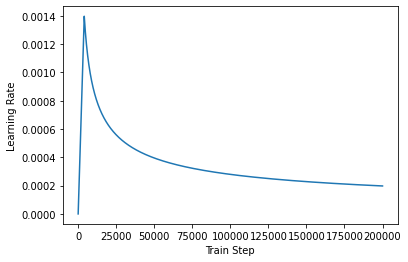

In [34]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### **4. 모델 컴파일**
***

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일함.

In [35]:
# 모델 컴파일하기

# 학습률 정하기
learning_rate = CustomSchedule(D_MODEL)

# 옵티마이저 정의하기
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 정확도 정의하기
def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 모델 컴파일하기
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### **5. 훈련하기**
***

이제 학습을 진행해보자.

In [36]:
# 학습 진행하기(훈련하기)
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
689/689 [==============================] - 45s 56ms/step - loss: 2.1108 - accuracy: 0.0427
Epoch 2/20
689/689 [==============================] - 38s 56ms/step - loss: 1.5000 - accuracy: 0.0787
Epoch 3/20
689/689 [==============================] - 38s 56ms/step - loss: 1.3963 - accuracy: 0.0857
Epoch 4/20
689/689 [==============================] - 38s 55ms/step - loss: 1.3359 - accuracy: 0.0904
Epoch 5/20
689/689 [==============================] - 38s 55ms/step - loss: 1.2374 - accuracy: 0.0980
Epoch 7/20
689/689 [==============================] - 38s 56ms/step - loss: 1.1825 - accuracy: 0.1021
Epoch 8/20
689/689 [==============================] - 38s 56ms/step - loss: 1.1199 - accuracy: 0.1076
Epoch 9/20
689/689 [==============================] - 38s 56ms/step - loss: 1.0618 - accuracy: 0.1137
Epoch 10/20
689/689 [==============================] - 38s 56ms/step - loss: 1.0085 - accuracy: 0.1193
Epoch 11/20
689/689 [==============================] - 38s 55ms/step - loss: 0.95

### **챗봇 테스트하기**
***

**예측(inference)** 단계는 기본적으로 다음과 같은 과정을 거침.
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, `START_TOKEN`과 `END_TOKEN`을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. `END_TOKEN`이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 `decoder_inference()` 함수를 만듦.

In [37]:
# decode_inference 함수 정의하기
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듦.

In [38]:
# sentence_generation 함수 만들기
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

임의의 문장으로부터 챗봇이 대답을 얻어보자.

In [39]:
sentence_generation('Where have you been?')

입력 : Where have you been?
출력 : i don t want to talk about it .


'i don t want to talk about it .'

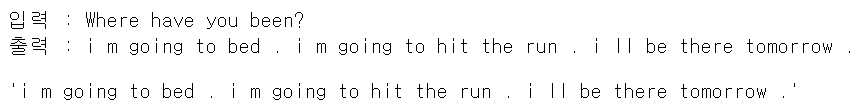

In [40]:
sentence_generation("It's a trap")

입력 : It's a trap
출력 : it s just that we re supposed to be a bad house .


'it s just that we re supposed to be a bad house .'

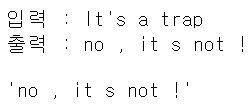

## **2. 실습(프로젝트)**

### **Step 1. 데이터 수집하기**
***

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

In [41]:
# 라이브러리 불러오기
import tensorflow as tf
import pandas as pd
import re
from konlpy.tag import Okt
import tensorflow_datasets as tfds

In [42]:
# 데이터 파일 경로 지정하기
data_file_path = '/aiffel/data/ChatbotData .csv'
# CSV 파일 읽어 DataFrame으로 불러오기
df = pd.read_csv(data_file_path)

In [43]:
# 데이터 살펴보기
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### **Step 2. 데이터 전처리하기**
***

영어 데이터와는 전혀 다른 데이터인 만큼 

영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 

전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [44]:
questions = df['Q'].tolist()  # 질문 컬럼을 리스트로 변환하기
answers = df['A'].tolist()  # 답변 컬럼을 리스트로 변환하기

In [45]:
# Okt 객체를 생성하여 okt 변수에 저장하기
# 이 객체를 사용하여 한국어 문장을 형태소 단위로 분석할 수 있음.
okt = Okt()

전처리 함수를 구현해보자.

In [46]:
# 전처리 함수 구현하기
def preprocess_sentence(sentence):
    # 문장을 소문자로 변환하고 양쪽 공백을 제거하기
    sentence = sentence.lower().strip()
    # 문장 부호 앞에 공백을 추가하기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 여러 개의 공백을 하나의 공백으로 변환하기
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 알파벳, 숫자, 한국어 문자를 제외한 모든 문자를 공백으로 변환하기
    sentence = re.sub(r"[^a-zA-Z가-힣0-9?.!,]+", " ", sentence)
    # 한국어 형태소 분석기를 사용하여 형태소 단위로 분리하기
    sentence = ' '.join(okt.morphs(sentence))
    return sentence.strip()

In [47]:
# 질문과 답변에 대해 전처리 함수를 적용해보자.

# 모든 질문 문장 전처리하기
questions = [preprocess_sentence(q) for q in questions]
# 모든 답변 문장 전처리하기
answers = [preprocess_sentence(a) for a in answers]

In [48]:
# 전처리된 질문과 답변 확인해보기
questions, answers

(['12시 땡 !',
  '1 지망 학교 떨어졌어',
  '3 박 4일 놀러 가고 싶다',
  '3 박 4일 정도 놀러 가고 싶다',
  'ppl 심하네',
  'sd 카드 망가졌어',
  'sd 카드 안 돼',
  'sns 맞팔 왜 안 하지',
  'sns 시간 낭비 인 거 아는데 매일 하는 중',
  'sns 시간 낭비 인데 자꾸 보게 됨',
  'sns 보면 나 만 빼고 다 행복 해보여',
  '가끔 궁금해',
  '가끔 뭐 하는지 궁금해',
  '가끔 은 혼자 인게 좋다',
  '가난한 자의 설움',
  '가만 있어도 땀 난다',
  '가상 화폐 쫄딱 망함',
  '가스 불 켜고 나갔어',
  '가스 불 켜놓고 나온거 같아',
  '가스 비 너무 많이 나왔다 .',
  '가스 비 비싼데 감기 걸리겠어',
  '가스 비 장난 아님',
  '가장 확실한 건 뭘 까 ?',
  '가족 여행 가기 로 했어',
  '가족 여행 고고',
  '가족 여행 어디 로 가지 ?',
  '가족 있어 ?',
  '가족 관계 알려 줘',
  '가족 끼리 여행 간다 .',
  '가족 들 보고 싶어',
  '가족 들 이랑 서먹해',
  '가족 들 이랑 서먹해졌어',
  '가족 들 이랑 어디 가지 ?',
  '가족 들 이랑 여행 갈거야',
  '가족 여행 가야 지',
  '가족 이 누구 야 ?',
  '가족 이랑 여행 가려고',
  '가족 한테 스트레스 풀었어',
  '가출 할까 ?',
  '가출 해도 갈 데 가 없어',
  '간만 에 떨리니까 좋더라',
  '간만 에 쇼핑 중',
  '간만 에 휴식 중',
  '간식 뭐 먹을까',
  '간식 추천',
  '간장 치킨 시켜야지',
  '간접흡연 싫어',
  '갈까 말까 고민 돼',
  '갈까 말까 ?',
  '감 말랭이 먹고 싶다 .',
  '감 말랭이 먹어야지',
  '감기 같 애',
  '감기 걸린 것 같아',
  '감기 기운 이 있어',
  '감기 들 거 같 애',
  '감기 가 오려나',
  '감기 약 이 없어',
  '감기

### **Step 3. SubwordTextEncoder 사용하기**
***

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 

하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [49]:
# SubwordTextEncoder 사용하기
import tensorflow_datasets as tfds

# 질문과 답변 데이터로부터 서브워드 텍스트 인코더 만들기
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

두 개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 함.

In [50]:
# 시작 토큰과 종료 토큰 설정하기
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
# 단어 사전의 크기 설정하기
VOCAB_SIZE = tokenizer.vocab_size + 2
# 최대 시퀀스 길이 설정하기
MAX_LENGTH = 50

시작 토큰과 종료 토큰에 부여된 정수를 출력해보자.

In [51]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [7274]
END_TOKEN의 번호 : [7275]


In [52]:
print('단어의 크기 :' ,VOCAB_SIZE)

단어의 크기 : 7276


최대 길이를 설정하고, 정수를 인코딩 및 패딩하자.

In [53]:
# 정수 인코딩 및 패딩하기(함수 구현하기)
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 입력 문장 인코딩하고 시작 및 종료 토큰 추가하기
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        # 출력 문장 인코딩하고 시작 및 종료 토큰 추가하기
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 문장이 최대 길이 이하인 경우
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)  # 토큰화된 입력 문장 추가하기
            tokenized_outputs.append(sentence2)  # 토큰화된 출력 문장 추가하기
       
    # 입력 문장 패딩하기
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    # 출력 문장 패딩하기
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    # 패딩된 문장들 반환하기
    return tokenized_inputs, tokenized_outputs

In [54]:
# 전처리된 질문과 답변을 정수 인코딩 및 패딩 처리하기
questions, answers = tokenize_and_filter(questions, answers)

In [55]:
# 결과 확인하기
questions, answers

(array([[7274, 5218,  713, ...,    0,    0,    0],
        [7274,  809,   88, ...,    0,    0,    0],
        [7274,  458, 1314, ...,    0,    0,    0],
        ...,
        [7274, 7255, 7175, ...,    0,    0,    0],
        [7274,  164,   85, ...,    0,    0,    0],
        [7274, 1680,  120, ...,    0,    0,    0]], dtype=int32),
 array([[7274,  233,    3, ...,    0,    0,    0],
        [7274,  332,   71, ...,    0,    0,    0],
        [7274,  230,   12, ...,    0,    0,    0],
        ...,
        [7274, 3679,  457, ...,    0,    0,    0],
        [7274,   20, 2204, ...,    0,    0,    0],
        [7274,  409,  642, ...,    0,    0,    0]], dtype=int32))

### **Step 4. 모델 구성하기**
***

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

인코더, 디코더, 포지셔널 인코딩, 멀티헤드 어텐션 등을 활용하기

**포지셔널 인코딩 클래스 구현하기**

트랜스포머 모델에서 위치 정보를 인코딩하기 위해 사용됨. 트랜스포머 모델은 입력 시퀀스의 순서를 고려하지 않기 때문에, 위치 정보를 추가하여 순서에 대한 정보를 제공해야 함.

In [56]:
# 포지셔널 인코딩 클래스 구현하기
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_position, d_model):
        # 부모 클래스(tf.keras.layers.Layer)의 생성자 호출하기
        super(PositionalEncoding, self).__init__()
        # 주어진 max_position과 d_model을 사용하여 positional encoding 계산하기
        self.pos_encoding = self.positional_encoding(max_position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))  # 각도(angles)를 계산하기
        return position * angles  # 위치(position)와 각도(angles)를 곱하여 반환하기

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],  # 위치 인덱스를 생성하기
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],  # 모델 차원 인덱스를 생성하기
            d_model=d_model)  # 모델 차원을 전달하기
        sines = tf.math.sin(angle_rads[:, 0::2])  # 사인 함수를 사용하여 짝수 인덱스의 각도 계산하기
        cosines = tf.math.cos(angle_rads[:, 1::2])  # 코사인 함수를 사용하여 홀수 인덱스의 각도 계산하기
        pos_encoding = tf.concat([sines, cosines], axis=-1)  # 사인과 코사인 값을 쌓아서 pos_encoding 만들기
        pos_encoding = pos_encoding[tf.newaxis, ...]  # 새로운 차원을 추가하여 배치를 지원하도록 하기
        return tf.cast(pos_encoding, tf.float32)  # pos_encoding을 float32 형식으로 변환하여 반환하기

    def call(self, inputs):
        # 레이어의 입력(inputs)에 위치 인코딩(pos_encoding)을 더하여 반환하기
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

**스케일드 닷 프로덕트 어텐션 함수 구현하기**

In [57]:
# 스케일드 닷 프로덕트 어텐션 함수 구현하기
def scaled_dot_product_attention(query, key, value, mask):
    # Query와 Key의 내적을 수행하여 어텐션 점수 계산하기
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    # Scaled factor를 적용하여 스케일링 수행하기
    dk = tf.cast(tf.shape(key)[-1], tf.float32)
    # 스케일링 된 어텐션 로짓 계산하기
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        # 마스크를 어텐션 로짓에 적용하기
        scaled_attention_logits += (mask * -1e9)
    # 어텐션 가중치 계산하기
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # 어텐션 가중치를 Value에 곱하여 최종 출력 계산하기
    output = tf.matmul(attention_weights, value)
    return output  # 최종 출력 반환하기

**멀티 헤드 어텐션 함수 구현하기**

입력을 여러 개의 '헤드'로 나누어 병렬로 어텐션을 수행한 후, 이 결과들을 결합하여 최종 출력을 생성함.

In [58]:
# 멀티 헤드 어텐션 함수 구현하기
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()  # 부모 클래스(tf.keras.layers.Layer)의 생성자 호출하기
        self.num_heads = num_heads  # num_heads 초기화하기
        self.d_model = d_model  # d_model 초기화하기
        assert d_model % self.num_heads == 0  # d_model은 num_heads로 나누어 떨어져야 하기
        self.depth = d_model // self.num_heads  # 각 헤드의 깊이 계산하기
        self.query_dense = tf.keras.layers.Dense(units=d_model)  # Query를 위한 Dense 레이어 정의하기
        self.key_dense = tf.keras.layers.Dense(units=d_model)  # Key를 위한 Dense 레이어 정의하기
        self.value_dense = tf.keras.layers.Dense(units=d_model)  # Value를 위한 Dense 레이어 정의하기
        self.dense = tf.keras.layers.Dense(units=d_model)  # 최종 출력 값을 위한 Dense 레이어 정의하기

    def split_heads(self, inputs, batch_size):
        # 입력을 (batch_size, 시퀀스 길이, num_heads, depth)로 재구성하기
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        # 텐서를 전치하여 (batch_size, num_heads, 시퀀스 길이, depth)로 만들기
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # 입력 딕셔너리에서 query, key, value, mask 추출하기
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]  # 배치 크기 구하기
        query = self.query_dense(query)  # Query에 Dense 레이어 적용하기
        key = self.key_dense(key)  # Key에 Dense 레이어 적용하기
        value = self.value_dense(value)  # Value에 Dense 레이어 적용하기
        query = self.split_heads(query, batch_size)  # Query를 여러 헤드로 나누기
        key = self.split_heads(key, batch_size)  # Key를 여러 헤드로 나누기
        value = self.split_heads(value, batch_size)  # Value를 여러 헤드로 나누기
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)  # Scaled Dot-Product Attention 적용하기
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # Attention 출력을 전치하여 원래 형태로 되돌리기
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # 전치된 출력을 연결하기
        outputs = self.dense(concat_attention)  # 연결된 출력에 Dense 레이어를 적용하여 최종 출력 만들기
        return outputs  # 최종 출력 반환하기

**패딩 마스크 생성 함수**

패딩 마스크는 시퀀스 내의 패딩 토큰을 무시하도록 하는 역할을 함.

트랜스포머 모델은 패딩 토큰을 의미 있는 단어로 인식해서는 안 되기 때문에, 패딩 마스크를 사용하여 패딩 위치를 가짐.

In [59]:
def create_padding_mask(x):
    # 입력 텐서에서 패딩 토큰(0)에 해당하는 위치 찾기
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # 마스크 텐서의 차원을 확장하여 (batch_size, 1, 1, seq_len) 형태로 만들기
    return mask[:, tf.newaxis, tf.newaxis, :]

**룩 어헤드 마스크 생성 함수**

디코더에서 다음 단어를 예측할 때 이전 단어들만을 참고하도록 하기 위해 사용됨.

현재 위치 이후의 단어들을 마스킹하여 볼 수 없도록 함.

In [60]:
# 룩 어헤드 마스크 생성 함수 구현하기
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]  # 시퀀스의 길이 구하기
    # 트라이앵글 마스크를 생성하여 상삼각 행렬 만들기
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)  # 패딩 마스크 생성하기
    # 룩 어헤드 마스크와 패딩 마스크를 결합하여 최종 마스크 만들기
    return tf.maximum(look_ahead_mask, padding_mask)

**인코더 레이어 생성 함수 및 인코더 생성 함수 구현하기**

인코더 레이어는 트랜스포머 모델의 기본 구성 요소로,

각 레이어는 **멀티 헤드 어텐션**과 **피드포워드 네트워크**로 구성됨.

In [61]:
# 인코더 레이어 생성 함수 구현하기
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")  # 입력 텐서 정의하기
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")  # 패딩 마스크 입력 텐서 정의하기
    attention = MultiHeadAttention(d_model, num_heads)({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })  # Multi-Head Attention 적용하기
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)  # 드롭아웃 적용하기
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)  # 잔차 연결 후 Layer Normalization 적용하기
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)  # 첫 번째 완전 연결 층 적용하기
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)  # 두 번째 완전 연결 층 적용하기
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)  # 드롭아웃 적용하기
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)  # 잔차 연결 후 Layer Normalization 적용하기
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)  # 인코더 레이어 모델 반환하기

In [62]:
# 인코더 생성 함수 구현하기
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, max_position, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")  # 입력 텐서 정의하기
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")  # 패딩 마스크 입력 텐서 정의하기
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)  # 임베딩 적용하기
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))  # 임베딩 값 스케일링하기
    embeddings = PositionalEncoding(max_position, d_model)(embeddings)  # 위치 인코딩 적용하기
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)  # 드롭아웃 적용하기
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i)
        )([outputs, padding_mask])  # 각 인코더 레이어 쌓기
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)  # 인코더 모델 반환하기

**디코더 레이어 생성 함수 및 디코더 생성 함수 구현하기**

디코더 레이어는 트랜스포머 모델의 기본 구성 요소로, **멀티 헤드 어텐션**과 **피드포워드 신경망**으로 구성됨.

디코더 레이어는 두 개의 멀티 헤드 어텐션을 포함하는데, **셀프 어텐션**과 **인코더-디코더 어텐션**임.

In [63]:
# 디코더 레이어 생성 함수 정의하기
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")  # 입력 텐서 정의하기
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")  # 인코더 출력 텐서 정의하기
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")  # 룩 어헤드 마스크 입력 텐서 정의하기
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')  # 패딩 마스크 입력 텐서 정의하기
    attention1 = MultiHeadAttention(d_model, num_heads)({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })  # 첫 번째 Multi-Head Attention 적용하기
    # 잔차 연결 후 Layer Normalization 적용하기
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    attention2 = MultiHeadAttention(d_model, num_heads)({
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })  # 두 번째 Multi-Head Attention 적용하기
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)  # 드롭아웃 적용하기
    # 잔차 연결 후 Layer Normalization 적용하기
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)  # 첫 번째 완전 연결 층 적용하기
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)  # 두 번째 완전 연결 층 적용하기
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)  # 드롭아웃 적용하기
    # 잔차 연결 후 Layer Normalization 적용하기
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    # 디코더 레이어 모델 반환하기
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [64]:
# 디코더 생성 함수 정의하기
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, max_position, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')  # 입력 텐서 정의하기
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')  # 인코더 출력 텐서 정의하기
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')  # 룩 어헤드 마스크 입력 텐서 정의하기
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')  # 패딩 마스크 입력 텐서 정의하기
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)  # 임베딩 적용하기
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))  # 임베딩 값 스케일링하기
    embeddings = PositionalEncoding(max_position, d_model)(embeddings)  # 위치 인코딩 적용하기
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)  # 드롭아웃 적용하기
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i)
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])  # 각 디코더 레이어 쌓기
    # 디코더 모델 반환하기
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], 
                          outputs=outputs, name=name)

**트랜스포머 모델 생성 함수**

트랜스포머 모델은 인코더와 디코더로 구성되며,

입력 시퀀스를 인코딩하고 디코딩하여 최종 출력을 생성함.

In [65]:
# 트랜스포머 모델 생성 함수 정의하기
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, max_position, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")  # 인코더 입력 텐서 정의하기
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")  # 디코더 입력 텐서 정의하기
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, 
                                              output_shape=(1, 1, None), 
                                              name='enc_padding_mask')(inputs)  # 인코더 패딩 마스크 생성하기
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, 
                                             output_shape=(1, None, None), 
                                             name='look_ahead_mask')(dec_inputs)  # 룩 어헤드 마스크 생성하기
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, 
                                              output_shape=(1, 1, None), 
                                              name='dec_padding_mask')(inputs)  # 디코더 패딩 마스크 생성하기
    enc_outputs = encoder(vocab_size, num_layers, 
                          units, d_model, num_heads, 
                          dropout, max_position)([inputs, enc_padding_mask])  # 인코더 출력 계산하기
    dec_outputs = decoder(vocab_size, num_layers, 
                          units, d_model, num_heads,
                          # 디코더 출력 계산하기
                          dropout, max_position)([dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)  # 최종 출력 Dense 레이어 정의하기
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)  # 트랜스포머 모델 반환하기

**하이퍼파라미터 설정 및 모델 생성하기**

트랜스 포머 모델을 생성하기 위해 필요한 하이퍼파라미터를 설정하고 모델을 설정해보자.

In [66]:
# 하이퍼파라미터 설정하기
NUM_LAYERS = 2  # 인코더와 디코더의 층의 개수 설정하기
D_MODEL = 256  # 인코더와 디코더 내부의 입, 출력의 고정 차원 설정하기
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수 설정하기
UNITS = 512  # 피드 포워드 신경망의 은닉층의 크기 설정하기
DROPOUT = 0.1  # 드롭아웃의 비율 설정하기
MAX_POSITION = 50  # 최대 시퀀스 길이 설정하기

In [67]:
# 트랜스포머 모델 생성하기
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_position=MAX_POSITION
)

In [68]:
# 모델 요약하기
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2916864     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### **Step 5. 모델 평가하기**
***

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [69]:
BATCH_SIZE = 64  # 배치 크기 설정하기
BUFFER_SIZE = 20000  # 버퍼 크기 설정하기

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))  # 데이터셋 만들기

dataset = dataset.cache()  # 데이터셋 캐싱하기
dataset = dataset.shuffle(BUFFER_SIZE)  # 데이터셋 셔플하기
dataset = dataset.batch(BATCH_SIZE)  # 배치 크기로 데이터셋 나누기
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [70]:
# 커스텀 학습률 스케줄링 정의하기
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()  # 부모 클래스(tf.keras.optimizers.schedules.LearningRateSchedule)의 생성자 호출하기
        self.d_model = d_model  # 모델 차원 수 초기화하기
        self.d_model = tf.cast(self.d_model, tf.float32)  # 모델 차원 수를 float32 형식으로 변환하기
        self.warmup_steps = warmup_steps  # 워밍업 단계 수 초기화하기

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)  # 첫 번째 인자 계산하기
        arg2 = step * (self.warmup_steps**-1.5)  # 두 번째 인자 계산하기
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)  # 학습률 계산하여 반환하기

In [71]:
# 트랜스포머 모델의 학습률을 조정하기 위한 커스텀 학습률 스케줄러 정의하기
learning_rate = CustomSchedule(D_MODEL)
# 커스텀 학습률 스케줄러를 사용하는 Adam 옵티마이저 정의하기
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [72]:
# 정확도 계산하는 함수 정의하기
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))  # y_true 텐서 재구성하기
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [73]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [74]:
# 손실 함수 정의하기
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))  # y_true 텐서 재구성하기
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred, from_logits=True)  # 손실 계산하기
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)  # 마스크 생성하기
    loss = tf.reduce_sum(loss * mask, axis=-1) / tf.reduce_sum(mask, axis=-1)  # 마스크를 적용하여 손실 계산하기
    return loss  # 손실 반환하기

In [75]:
# 모델 컴파일하기
model.compile(optimizer=optimizer, 
              loss=loss_function, 
              metrics=[accuracy])

In [91]:
# 학습 에포크 수 설정하고 모델 학습하기
EPOCHS = 100  # 학습 에포크 수 설정하기
model.fit(dataset, epochs=EPOCHS, verbose=1)  # 모델 학습하기

Epoch 1/100
185/185 [==============================] - 12s 66ms/step - loss: 0.0285 - accuracy: 0.1593
Epoch 2/100
185/185 [==============================] - 12s 66ms/step - loss: 0.0269 - accuracy: 0.1594
Epoch 3/100
185/185 [==============================] - 12s 65ms/step - loss: 0.0275 - accuracy: 0.1593
Epoch 4/100
185/185 [==============================] - 12s 65ms/step - loss: 0.0263 - accuracy: 0.1594
Epoch 5/100
185/185 [==============================] - 12s 64ms/step - loss: 0.0262 - accuracy: 0.1594
Epoch 6/100
185/185 [==============================] - 12s 64ms/step - loss: 0.0245 - accuracy: 0.1595
Epoch 7/100
185/185 [==============================] - 12s 65ms/step - loss: 0.0249 - accuracy: 0.1595
Epoch 8/100
185/185 [==============================] - 12s 65ms/step - loss: 0.0231 - accuracy: 0.1595
Epoch 9/100
185/185 [==============================] - 12s 66ms/step - loss: 0.0241 - accuracy: 0.1596
Epoch 10/100
185/185 [==============================] - 12s 64ms/step - l

In [92]:
# 입력 문장을 기반으로 챗봇이 예측한 답변을 정수 시퀀스로 생성하기
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)  # 입력 문장 전처리하기
    sentence = tf.expand_dims(
        # 입력 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰 추가하기
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    output_sequence = tf.expand_dims(START_TOKEN, 0)  # 디코더의 현재까지의 예측한 출력 시퀀스 초기화하기
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)  # 디코더의 인퍼런스 단계 수행하기
        predictions = predictions[:, -1:, :]  # 현재 예측한 단어의 정수 추출하기
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)  # 예측한 단어의 정수 계산하기
        if tf.equal(predicted_id, END_TOKEN[0]):
            break  # 종료 토큰을 예측한 경우 반복 종료하기
            # 예측한 단어들을 지속적으로 output_sequence에 추가하기
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    return tf.squeeze(output_sequence, axis=0)  # 최종 예측된 출력 시퀀스 반환하기

In [93]:
# 입력 문장을 기반으로 챗봇이 예측한 답변을 텍스트로 변환하여 출력하기
def sentence_generation(sentence):
    # # 입력 문장에 대해 디코더를 동작 시켜 예측된 정수 시퀀스 리턴받기
    prediction = decoder_inference(sentence)
    predicted_sentence = tokenizer.decode(
        # 정수 시퀀스를 다시 텍스트 시퀀스로 변환하기
        [i for i in prediction if i < tokenizer.vocab_size])
    print('입력 : {}'.format(sentence))  # 입력 문장 출력하기
    print('출력 : {}'.format(predicted_sentence))  # 출력 문장 출력하기
    return predicted_sentence  # 예측된 문장 반환하기

### STEP 6. 실험 결과 확인하기
***

In [94]:
# 임의의 문장으로부터 챗봇이 답변을 받도록 구성하기
sentence_generation('안녕하세요!')  # 예시 문장을 입력하여 챗봇의 답변 확인하기

입력 : 안녕하세요!
출력 : 안녕하세요 .


'안녕하세요 .'

**에포크 20일 때**

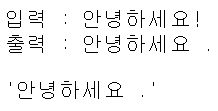

**에포크 50일 때**

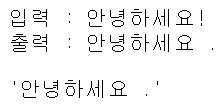

기분이 좋지 않을 때(부정의 감정)

In [98]:
sentence_generation('나 오늘 너무 힘들어..')

입력 : 나 오늘 너무 힘들어..
출력 : 찾아보지 마세요 .


'찾아보지 마세요 .'

**에포크 20일 때**

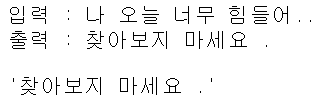

**에포크 50일 때**

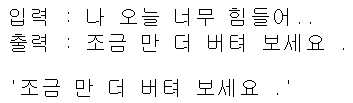

기분이 좋을 때(긍정의 감정)

In [99]:
sentence_generation('나 오늘 기분 너무 좋아 :D')

입력 : 나 오늘 기분 너무 좋아 :D
출력 : 다시 새로 사는 게 마음 편해요 .


'다시 새로 사는 게 마음 편해요 .'

**에포크 20일 때**

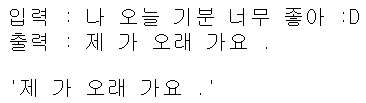

**에포크 50일 때**

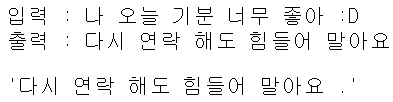

배고플 때

In [100]:
sentence_generation('엄청 배고프다.. 오늘 뭐먹지..?')

입력 : 엄청 배고프다.. 오늘 뭐먹지..?
출력 : 찾아보지 마세요 .


'찾아보지 마세요 .'

**에포크 20일 때**

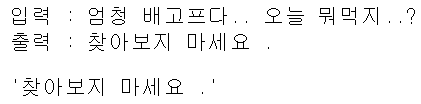

**에포크 50일 때**

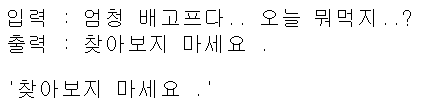

## **3. 회고**
***

**[느낀 점 & 배운 점]**

이번 프로젝트에서는 저번 LSTM 방식과 달리 Transformer 방식으로 문답을 주고 받는 챗봇을 만들어보았다. 학부생 때는 구글 클라우드의 API를 가져와 라인 환경에 얹히는 방식으로 프로젝트를 진행했지만, 이번에는 직접 그 원리에 대해서 배울 수 있어서 뜻깊은 프로젝트가 되지 않았나 싶다. 이번 프로젝트를 진행하면서 과거에 진행했던 챗봇도 다시 확인해봤는데, 과거의 나를 다시 볼 수 있는 계기가 된 것 같아서, 초심으로 돌아간 것 같은 기분을 느꼈다. Transformer 모델에 대해서 아직도 엄청 잘 아는 것은 아니지만, 직접 이러한 모델로 챗봇까지 구현할 수 있어서 좋았다. 앞으로 계속 Transformer 모델과 친하게 지내야 할 것 같은데, 이번 프로젝트를 보면서 항상 복습의 계기로 삼아야겠다는 생각이 들었다.

**[아쉬운 점 & 어려웠던 점]**

앞서 언급했다시피 Transformer 모델이 지금까지 봤던 모델 중에 가장 어렵고, 외워야 할 개념이 많아서 아직 다 익히지를 못했다. 다행히도 유튜브와 chatgpt라는 아주 친근한 친구들이 있기 때문에, 얘네한테 물어보면서 transformer 모델과 더 친해져야 할 것 같다. 아쉬웠던 점은 데이터셋이 적어서 그런지는 모르겠는데, 답변 정확률이 굉장히 떨어지는 것 같았다. 이를 향상하기 위한 방법에는 무엇이 있을까...가 아마 이번주 숙제가 아닐까 싶다.

* [Transformers, explained: Understand the model behind GPT, BERT, and T5(Google Cloud Tech)](https://www.youtube.com/watch?v=SZorAJ4I-sA&t=12s)
* [ransformer models and BERT model: Overview(Google Cloud Tech)](https://www.youtube.com/watch?v=t45S_MwAcOw&t=577s)